In [861]:
### import necessary packages
import uproot
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
from itertools import permutations, product, combinations, chain


In [862]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)  # allows duplicate elements
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [863]:
### transforms a root file in a single index file
### had issues reading out the multiindex file although I think this is the way to go for an optimized script
### the function also sorts in zp for the further analysis
def transform_root_file_and_sort_by_z(filename):
    events=uproot.open(filename)["events"]
    events2=events["events"]# why do I have to do that
    df =  events2.pandas.df(["ed", "zp","xp","yp","trackid","parentid","etot"]) # make a pandas data frame with the parameters of interest
    df2 = df.sort_values('zp', ascending=False).sort_index(level='entry', sort_remaining=False) # sort by z
    df3 = df2.reset_index(level="entry") # remove multiindex1
    df4 = df3.reset_index(level="subentry") # remove multiindex2
    return df4

In [864]:
### this is most likely outdated and was a solution where I included the first and last index in separate cases.

def get_data_frame_with_summed_energy_complicated(df4,z_res):
    energy_in_one = 0
    energy_list = []
    event_list = []
    energy_tot_list = []
    for j in df4.index:
    #tqdm(df4.index):#len(df2.groupby(level=0))):
        #print(df4["zp"][j])
        #print(energy_in_one,j,df4["zp"][j],"start",df4["ed"][j])
        #print(np.abs(df4["zp"][j+1]-df4["zp"][j]),"diff_high")
        #print(np.abs(df4["zp"][j-1]-df4["zp"][j]),"diff_low")       
            if(j==0): # first index
                if((np.abs(df4.at[j+1,"zp"]-df4.at[j,"zp"]))<z_res and df4.at[j,"entry"]==df4.at[j+1,"entry"] ): # check whether two subsequent indices are within the same z
                    #print((np.abs(df4["zp"][j+1]-df4["zp"][j])),"1")
                    energy_in_one+=df4.at[j,"ed"] # if so, add it to summed energy
            elif(j>0 and j<(len(df4)) and (np.abs(df4.at[j-1,"zp"]-df4.at[j,"zp"]))<z_res and df4.at[j,"entry"]==df4.at[j-1,"entry"]):    
                    energy_in_one+=df4.at[j,"ed"]
                    #print(df4["zp"][j],(np.abs(df4["zp"][j-1]-df4["zp"][j])),"3")  
            elif(df4.at[j,"entry"]!=df4.at[j+1,"entry"]) :
                    energy_list.append(energy_in_one)
                    event_list.append(df4.at[j,"entry"])
                    energy_tot_list.append(df4.at[j,"etot"])
                    energy_in_one = df4.at[j,"ed"]    
            elif(j==(len(df4))): # last index (not working properly)
                if((np.abs(df4.at[j-1,"zp"]-df4.at[j,"zp"]))<z_res and df4.at[j,"entry"]==df4.at[j-1,"entry"]):
                    energy_in_one+=df4.at[j,"ed"]
                    #print((np.abs(df4["zp"][j+1]-df4["zp"][j])),"2")
            else:   # if resolveable, write out the energy summed so far                    
                    #print(df4["zp"],(np.abs(df4["zp"][j-1]-df4["zp"][j])),"4")
                    #print((np.abs(df4["zp"][j+1]-df4["zp"][j])),"5")
                    energy_list.append(energy_in_one)
                    event_list.append(df4.at[j-1,"entry"])
                    energy_tot_list.append(df4.at[j-1,"etot"])
                    energy_in_one = df4.at[j,"ed"]   

    df_new = pd.DataFrame()
    df_new["event_id"] = event_list
    df_new["energy"] = energy_list
    df_new["etot"] = energy_tot_list
    return df_new
    


In [865]:
### function to obtain summed energy using z resolution only
### the code scans trough the data frame and adds up energy values until it is resolvable in z
### code is added to a list and put back in a df 

### toDO: there is a lot of ways to improve the efficience (benchmark at the moment on my machine 5min for 100k, 45min for 1M events)
### toDO: the first and  the last energies are not correctly handled


def get_data_frame_with_summed_energy(df4,z_res): #pick a resolution in z and a data frame
    energy_in_one = 0 # initialize the variable to add energy if below z_res
    energy_list = [] # lists for later
    event_list = []
    energy_tot_list = []
    for j in df4.index:
    #tqdm(df4.index):#len(df2.groupby(level=0))):
      if(j>0 and j<(len(df4))): #ignore last and first event since it is annoying when doing +-1
            if((np.abs(df4.at[j-1,"zp"]-df4.at[j,"zp"]))<z_res and (df4.at[j,"entry"]==df4.at[j-1,"entry"])): #if same event and below z_res add up   
                    energy_in_one+=df4.at[j,"ed"] 
            elif(df4.at[j,"entry"]!=df4.at[j+1,"entry"]) : # if the event ends, add into the list the energy which is stored at the moment
                    energy_list.append(energy_in_one)
                    event_list.append(df4.at[j,"entry"]) # 
                    energy_tot_list.append(df4.at[j,"etot"])
                    energy_in_one = df4.at[j,"ed"]    
            else:   # if resolveable, write out the energy summed so far                    
                    energy_list.append(energy_in_one)
                    event_list.append(df4.at[j-1,"entry"]) # j-1, since we are at a point where J is already from the next event
                    energy_tot_list.append(df4.at[j-1,"etot"])
                    energy_in_one = df4.at[j,"ed"]      

    df_new = pd.DataFrame()
    df_new["event_id"] = event_list
    df_new["energy"] = energy_list
    df_new["etot"] = energy_tot_list
    return df_new
    


In [866]:
### in progress
### toDO: x,y is not sorted. So there may be events which bounce crazy and cause problems if they are at the same z, this has to be checked
### toDO: the first and the last are not handled

def get_data_frame_with_summed_energy_xy(df4,z_res,xy_res):
    energy_in_one = 0
    energy_list = []
    event_list = []
    energy_tot_list = []
    for j in df4.index:
        if(j>0 and j<(len(df4))):
            if  (df4.at[j,"entry"]==df4.at[j-1,"entry"] 
            and ((np.abs(df4.at[j-1,"zp"]-df4.at[j,"zp"])<z_res))
            and ((np.abs(df4.at[j-1,"xp"]-df4.at[j,"xp"])<xy_res)) 
            and ((np.abs(df4.at[j-1,"yp"]-df4.at[j,"yp"])<xy_res))):
                            energy_in_one+=df4.at[j,"ed"]
            elif(df4.at[j,"entry"]!=df4.at[j+1,"entry"]) :
                    energy_list.append(energy_in_one)
                    event_list.append(df4.at[j,"entry"])
                    energy_tot_list.append(df4.at[j,"etot"])
                    energy_in_one = df4.at[j,"ed"]    
            else:   # if resolveable, write out the energy summed so far                    
                    energy_list.append(energy_in_one)
                    event_list.append(df4.at[j-1,"entry"])
                    energy_tot_list.append(df4.at[j-1,"etot"])
                    energy_in_one = df4.at[j,"ed"] # j is the stored energy. The results look alright, but does this make problems in border cases?
                
        #else  print(j)
            
    df_new_with_xy  = pd.DataFrame() # make a new dataframe to fill with results (ladies and gentlemen, mr.inefficient)
    df_new_with_xy ["event_id"] = event_list # the event_id
    df_new_with_xy ["energy"] = energy_list # the energy
    df_new_with_xy ["etot"] = energy_tot_list # the total energy deposition, important for cuts later but also cross check 
    return df_new_with_xy    

In [1051]:
def get_number_of_scatter(df_new,number_of_events=10000,multiplicity=2): # number of events can be set by the length of your file (toDO: it may need a correction by 2), multiplicity is simply how many scatter you want
    scatter_list = [] # I love lists apparently
    fraction_above_multi = 0 # will be the final value for the fraction above a certain multiplicity
    for i in np.arange(0,df_new.at[df_new.index[-1], 'event_id']):
        scatter_list.append(len(df_new[df_new['event_id'] == i]))
    ## list comprehension below, isn't faster
    #different_num = [len(df_new[df_new['event_id'] == i]) for i in np.arange(0,df_new.at[df_new.index[-1], 'event_id'])]
    fraction_above_multi = np.divide(np.count_nonzero(np.asarray(scatter_list)>(multiplicity-1)),number_of_events) # just count all events above a certain multiplicity and calculate a ratio to the total events
    return fraction_above_multi

In [1052]:

df4 = transform_root_file_and_sort_by_z("test10k_vol.root")

In [1053]:
fraction_list = []
res_values = np.arange(10,50,10)
for i in res_values:
    fraction_list.append(get_number_of_scatter(get_data_frame_with_summed_energy(df4,i)))
fraction_list    

[0.783, 0.5543, 0.3777, 0.2611]

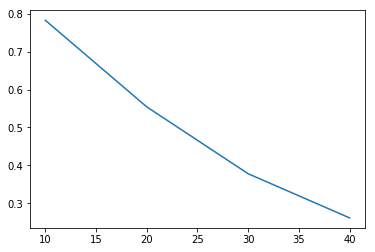

In [1054]:
plt.plot(np.arange(10,50,10),fraction_list)

In [1055]:
df_z = get_data_frame_with_summed_energy(df4,10)
df_xy = get_data_frame_with_summed_energy_xy(df4,10,10)

In [1056]:
## test for inconsistencies. only first and last usually respond
'''
for i in np.arange(0,10001,1):
    if(np.abs(np.sum(df_z.energy[df_z["event_id"]==i])-(np.sum(df_z.etot[df_z["event_id"]==i])/len(df_z.etot[df_z["event_id"]==i])))>3):
        print(np.sum(df_z.energy[df_z["event_id"]==i]),np.sum(df_z.etot[df_z["event_id"]==i])/len(df_z.etot[df_z["event_id"]==i]))
'''    

'\nfor i in np.arange(0,10001,1):\n    if(np.abs(np.sum(df_z.energy[df_z["event_id"]==i])-(np.sum(df_z.etot[df_z["event_id"]==i])/len(df_z.etot[df_z["event_id"]==i])))>3):\n        print(np.sum(df_z.energy[df_z["event_id"]==i]),np.sum(df_z.etot[df_z["event_id"]==i])/len(df_z.etot[df_z["event_id"]==i]))\n'

In [1069]:
fraction_list = []
for i in np.arange(10,50,10):
    fraction_list.append(get_number_of_scatter(get_data_frame_with_summed_energy(df4,i),number_of_events=10000,multiplicity=3))
f1 = fraction_list    

fraction_list = []
for i in np.arange(10,50,10):
    fraction_list.append(get_number_of_scatter(get_data_frame_with_summed_energy_xy(df4,i,30),number_of_events=10000,multiplicity=3))
f3 = fraction_list    

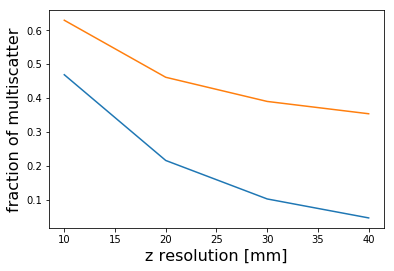

In [1070]:
x = np.arange(10,50,10)
plt.plot(x,f1)
plt.plot(x,f3)
plt.xlabel("z resolution [mm]",fontsize="16")
plt.ylabel("fraction of multiscatter",fontsize="16")
plt.show()

In [1073]:
### adding energy requirements ###
### toDO: make energy resolution dependent on the energy 
### toDo: make permutations work with number of 511 kev counts larger than 2. At the moment it counts depositions multiple times and any 0 depositions is like a joker for the other 511 keV deposition

def energy_criteria_selection(df,e_res,decay,how_many_511=1,permu=False):
    if(decay=="positron_test"):
        ## first we want only events which left the entire energy in the detetor
        df = df[df["etot"].between(2022-e_res,2022+e_res)] # this works since we have the tot column all the same within one evt_id
        ## second we want only events where the positron left its energy in one deposition
        criteria2 = df["energy"].between(1000-e_res,1000+e_res)
        criteria_sum = criteria2
        list_index2 = df[criteria_sum]["event_id"]
        df = df[df['event_id'].isin(list_index2)]

        ## third we want to pick those events where 511 keV are deposited completed, as often as we require
        ## can be used to filter for at least one full deposition
        df_mult = df[df["energy"].between(511-e_res,511+e_res)] # apply your criteria, here 511 keV depositions 
        list_index3 = df_mult["event_id"] # get all event_ids left so far
        list_index4=  df_mult.groupby('event_id')["energy"].count() # group the event_ids full_filling and count how often
        list_index5 = [] # create an empty list because you are AlexF the list fetish guy
        for i in list_index3.unique(): # check for all event_ids (but only once, hence the unique) if they fulfill the criteria
            if(list_index4[i]>(how_many_511-1)): # if the number of event_ids in the df_mult frame exceeds a certain number (here 1), save the event_id
                list_index5.append(i)
        df_perm = df[~df['event_id'].isin(list_index5)]
        df = df[df['event_id'].isin(list_index5)] # now go back to your original dataframe and select only those events which have the respective multiple scatters
        
        
        ## third we want to pick only those events where an algorithm would reconstruct 511 keV photons out of various energy depositions
        if(permu==True): # permutations are not the same as combinations but screw it...
            loop_group = df_perm.groupby("event_id") # group them by event id
            list_index6 = [] # make some more lists
            list_index7= [] # oh yeah 
            list_index8 = [] # list it to me baby
            for i in np.unique(df_perm.event_id): # now check all event ids in the dataframe
                loop_group.get_group(i) # and look into the values
                list_index7 = list(combinations(loop_group.get_group(i).energy,1)) # build a list of all possible combinations of energy given the event_id
                for j, combo in enumerate(powerset(list_index7), 1): # powerset now goes from single entries to combinations of all entries
                    if(np.sum(combo)>(511-e_res) and np.sum(combo)<(511.+e_res)): # check the sum and append it if fulfills your criterion
                        list_index6.append(i) 
                if(list_index6.count(i)>(how_many_511-1)): # count how often for a given event you have fulfilled it
                    list_index8.append(i) # add only those where the event fulfills the desired number of combinations
            #uniq_evt = np.unique(list_index6)
            df_perm = df_perm[df_perm['event_id'].isin(list_index8)]  # filter the frame
            frames=[df,df_perm] # add the frames together, since you have already checked for the full depositons
            df=pd.concat(frames)
        

    
    '''    
    if(decay=="2vECB+"): 
    elif(decay=="2vB+B+"):
    elif(decay=="0vECB+"):
    elif(decay=="0vRECEC"):
    elif(decay=="0vECEC"):
    elif(decay=="2vECB+"):
    '''
    return df
    

In [1077]:
def get_surival_fraction_after_energy(inital_events,df_original,z_res,xy_res,e_res,decay,how_many_511=1,permu=False):
    df_temp = energy_criteria_selection(get_data_frame_with_summed_energy_xy(df_original,z_res,xy_res),e_res,decay,how_many_511,permu)
    fraction = len(np.unique(df_temp.event_id))/inital_events*100
    return fraction

In [ ]:
get_surival_fraction_after_energy(10000,df4,30,3000,100,"positron_test",2,True)